In [1]:
"""
To make sure the fusion decomposition works
up to the part where we would stitch the sublimbs together into one limb


"""

'\nTo make sure the fusion decomposition works\nup to the part where we would stitch the sublimbs together into one limb\n\n\n'

In [2]:
from os import sys
sys.path.append("/meshAfterParty/")

In [3]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu
import neuron_utils as nru

#importing at the bottom so don't get any conflicts
import itertools
from tqdm_utils import tqdm

#for meshparty preprocessing
import meshparty_skeletonize as m_sk
import general_utils as gu
import compartment_utils as cu
from meshparty import trimesh_io
from copy import deepcopy


from neuron_utils import *


# Downloading the Neuron

In [4]:
import datajoint_utils as du

INFO:datajoint.settings:Setting database.host to at-database.ad.bcm.edu
INFO:datajoint.settings:Setting database.user to celiib
INFO:datajoint.settings:Setting database.password to newceliipass
INFO:datajoint.settings:Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO:datajoint.settings:Setting enable_python_native_blobs to True
INFO:datajoint.settings:Setting enable_python_native_blobs to True


Connecting celiib@at-database.ad.bcm.edu:3306


In [5]:
import neuron_visualizations as nviz

In [7]:
segment_id = 864691135471571396

print(f"curr_segment_id = {segment_id}")
current_neuron = du.fetch_segment_id_mesh(segment_id)
nviz.plot_objects(current_neuron)

description = "triple_soma_error"

curr_segment_id = 864691135471571396


/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Loading the Neuron

In [ ]:
# import trimesh_utils as tu
# curent_neuron = tu.load_mesh_no_processing("/notebooks/test_neurons/Segmentation_2/864691135738362516_thin_long_down_axon.off")
# segment_id = 864691135738362516
# description = "thin_long_down_axon"

# import neuron_visualizations as nviz
# nviz.plot_objects(main_mesh=curent_neuron)

# Setting the Arguments that would be present inside a preprocessing function call

In [8]:
#predefined arguments for the Neuron constructor

decomposition_type="meshafterparty"
mesh_correspondence="meshparty" #meshafterparty_adaptive
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
meshparty_adaptive_correspondence_after_creation=False
suppress_preprocessing_print=True
computed_attribute_dict=None
somas = None
branch_skeleton_data=None
combine_close_skeleton_nodes = True
combine_close_skeleton_nodes_threshold=700
ignore_warnings=True
suppress_output=False
calculate_spines=True
widths_to_calculate=["no_spine_median_mesh_center"]
fill_hole_size=2000

In [9]:
#arguments for the preprocess neuron
mesh = current_neuron
segment_id=segment_id
description=description

sig_th_initial_split=15 #for significant splitting meshes in the intial mesh split
limb_threshold = 2000 #the mesh faces threshold for a mesh to be qualified as a limb (otherwise too small)
filter_end_node_length=4001 #used in cleaning the skeleton during skeletonizations
return_no_somas = False

decomposition_type=decomposition_type
mesh_correspondence=mesh_correspondence
distance_by_mesh_center=distance_by_mesh_center
meshparty_segment_size =meshparty_segment_size
meshparty_n_surface_downsampling = meshparty_n_surface_downsampling
somas=somas
branch_skeleton_data=branch_skeleton_data
combine_close_skeleton_nodes = combine_close_skeleton_nodes
combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold

# Setting up the metadata

In [10]:
whole_processing_tiempo = time.time()


"""
Purpose: To process the mesh into a format that can be loaded into the neuron class
and used for higher order processing (how to visualize is included)

"""
if description is None:
    description = "no_description"
if segment_id is None:
    #pick a random segment id
    segment_id = np.random.randint(100000000)
    print(f"picking a random 7 digit segment id: {segment_id}")
    description += "_random_id"


if mesh is None:
    if current_mesh_file is None:
        raise Exception("No mesh or mesh_file file were given")
    else:
        current_neuron = trimesh.load_mesh(current_mesh_file)
else:
    current_neuron = mesh

# ************************ Phase A: Soma and Limb Identification ********************************

In [11]:
# --- 1) Doing the soma detection
if somas is None:
    soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)
else:
    soma_mesh_list,run_time,total_soma_list_sdf = somas

# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
    if return_no_somas:
        return_value= soma_mesh_list_centers
    raise Exception("Processing of No Somas is not yet implemented yet")
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 9484 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/864691135471571396/neuron_864691135471571396.off -o /notebooks/Platinum_Decomp_Fusion/864691135471571396/neuron_864691135471571396_decimated.off -s /notebooks/Platinum_Decomp_Fusion/864691135471571396/decimation_meshlab_25160243.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(9255, 3), faces.shape=(23395, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(9255, 3), faces.shape=(23395, 3))>
pre_largest_mesh_path = /notebooks/Platinum_Decomp_Fusion/864691135471571396/neuron_864691135471571396_decimated_largest_piece.off
xvfb-run -n 7957 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/P

removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_470253.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_470253_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_423445.mls is being deleted....
Inside sphere validater: ratio_val = 5.031424592205093
Soma List = [<trimesh.Trimesh(vertices.shape=(748, 3), faces.shape=(1692, 3))>, <trimesh.Trimesh(vertices.shape=(667, 3), faces.shape=(1495, 3))>]
soma_mesh_list_centers = [array([1255656.67112299,  801413.90748663,  988112.30080214]), array([1285277.6131934 ,  790706.47271364, 1011040.59070465])]


In [12]:
#--- 2) getting the soma submeshes that are connected to each soma and identifiying those that aren't (and eliminating any mesh pieces inside the soma)

main_mesh_total = current_neuron


#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list,
                                        split_meshes)

# filtering away any of the inside floating pieces: 
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """

    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]


#     print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
#     print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")






# total split meshes = 3
There were 2 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0, 1]}


In [13]:
tu = reload(tu)
#--- 3)  Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

#     sk.graph_skeleton_and_mesh(other_meshes=[soma_meshes])

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print(f"\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    current_time = time.time()
    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)
    print(f"Total time for Subtract Soam = {time.time() - current_time}")
    current_time = time.time()

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)

    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    print(f"Total time for Original_mesh_faces_map for mesh_pieces without soma= {time.time() - current_time}")
    current_time = time.time()
    soma_meshes = current_mesh.submesh([soma_faces],append=True,repair=False)

    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True,repair=False)

    print(f"Total time for Original_mesh_faces_map for somas= {time.time() - current_time}")
    current_time = time.time()

    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)

    print(f"Total time for sig_non_soma_pieces= {time.time() - current_time}")
    current_time = time.time()

    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces

    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    #take the top largest ones depending how many were originally in the soma list
    seperate_soma_meshes = seperate_soma_meshes[:len(soma_mesh_list)]
    soma_face_components = soma_face_components[:len(soma_mesh_list)]

    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes

    print(f"Total time for split= {time.time() - current_time}")
    current_time = time.time()



    soma_to_piece_connectivity = dict()
    soma_to_piece_touching_vertices = dict()
    soma_to_piece_touching_vertices_idx = dict()
    limb_root_nodes = dict()
    
    m_vert_graph = tu.mesh_vertex_graph(current_mesh)
    
    for i,curr_soma in enumerate(seperate_soma_meshes):
        (connected_mesh_pieces,
         connected_mesh_pieces_vertices,
         connected_mesh_pieces_vertices_idx) = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True,
                        return_vertices_idx=True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces

        soma_to_piece_touching_vertices[i] = dict()
        for piece_index,piece_idx in enumerate(connected_mesh_pieces):
            limb_root_nodes[piece_idx] = connected_mesh_pieces_vertices[piece_index][0]
            
            """ Old way of finding vertex connected components on a mesh without trimesh function
            #find the number of touching groups and save those 
            soma_touching_graph = m_vert_graph.subgraph(connected_mesh_pieces_vertices_idx[piece_index])
            soma_con_comp = [current_mesh.vertices[np.array(list(k)).astype("int")] for k in list(nx.connected_components(soma_touching_graph))]
            soma_to_piece_touching_vertices[i][piece_idx] = soma_con_comp
            """
            
            soma_to_piece_touching_vertices[i][piece_idx] = tu.split_vertex_list_into_connected_components(
                                                vertex_indices_list=connected_mesh_pieces_vertices_idx[piece_index],
                                                mesh=current_mesh, 
                                                vertex_graph=m_vert_graph, 
                                                return_coordinates=True
                                               )
            
            
            
            

#         border_debug = False
#         if border_debug:
#             print(f"soma_to_piece_connectivity = {soma_to_piece_connectivity}")
#             print(f"soma_to_piece_touching_vertices = {soma_to_piece_touching_vertices}")


    print(f"Total time for mesh_pieces_connectivity= {time.time() - current_time}")

    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")



# Lets have an alert if there was more than one soma disconnected meshes
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

current_mesh_data = soma_touching_mesh_data
soma_containing_idx = 0

#doing inversion of the connectivity and touching vertices
piece_to_soma_touching_vertices = gu.flip_key_orders_for_dict(soma_to_piece_touching_vertices)


# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***



----Working on soma-containing mesh piece 0----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(31420, 3), faces.shape=(66700, 3))>, <trimesh.Trimesh(vertices.shape=(5171, 3), faces.shape=(10371, 3))>]
There were 2 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(31420, 3), faces.shape=(66700, 3))>, <trimesh.Trimesh(vertices.shape=(5171, 3), faces.shape=(10371, 3))>]
Total Time for soma mesh cancellation = 0.213
Total time for Subtract Soam = 0.21416258811950684
Total time for Original_mesh_faces_map for mesh_pieces without soma= 0.06694221496582031
Total time for Original_mesh_faces_map for somas= 0.05743718147277832
Total time for sig_non_soma_pieces= 0.07738685607910156
Total time for split= 0.019165754318237305


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


Total time for mesh_pieces_connectivity= 0.8974361419677734
# of insignificant_limbs = 0 with trimesh : []


# Process that will start for each limb

In [114]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
m_sk = reload(m_sk)
pre = reload(pre)
xu = reload(xu)
nu = reload(nu)
gu = reload(gu)

try: 
    proper_time = time.time()

    #The containers that will hold the final data for the preprocessed neuron
    limb_correspondence=dict()
    limb_network_stating_info = dict()

    # ---------- Part A: skeletonization and mesh decomposition --------- #
    skeleton_time = time.time()

    for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):

        #Arguments to pass to the specific function (when working with a limb)
        soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]

    #     if curr_limb_idx != 10:
    #         continue

        curr_limb_time = time.time()
        print(f"\n\n----- Working on Proper Limb # {curr_limb_idx} ---------")


        limb_correspondence_individual,network_starting_info = pre.preprocess_limb(mesh=limb_mesh_mparty,
                       soma_touching_vertices_dict = soma_touching_vertices_dict,
                       return_concept_network = False, 
                       return_concept_network_starting_info=True,
                       width_threshold_MAP=500,
                       size_threshold_MAP=2000,
                       surface_reconstruction_size=1000,                                                            
                       )
        #Storing all of the data to be sent to 

        limb_correspondence[curr_limb_idx] = limb_correspondence_individual
        limb_network_stating_info[curr_limb_idx] = network_starting_info

    #     raise Exception("Done with #10")


    print(f"Total time for Skeletonization and Mesh Correspondence = {time.time() - skeleton_time}")

    pre=reload(pre)
    neuron=reload(neuron)
    nru = reload(nru)
    # ---------- Part B: Stitching on floating pieces --------- #
    floating_stitching_time = time.time()

    limb_correspondence_with_floating_pieces = pre.attach_floating_pieces_to_limb_correspondence(
            limb_correspondence,
            floating_meshes=non_soma_touching_meshes,
            floating_piece_face_threshold = 600,
            max_stitch_distance=8000,
            distance_to_move_point_threshold = 4000,
            verbose = False)



    print(f"Total time for stitching floating pieces = {time.time() - floating_stitching_time}")





    # ---------- Part C: Computing Concept Networks --------- #
    concept_network_time = time.time()

    limb_concept_networks=dict()
    limb_labels=dict()

    for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
        limb_to_soma_concept_networks = pre.calculate_limb_concept_networks(limb_correspondence_with_floating_pieces[curr_limb_idx],
                                                                            run_concept_network_checks=True,
                                                                           **limb_network_stating_info[curr_limb_idx])   



        limb_concept_networks[curr_limb_idx] = limb_to_soma_concept_networks
        limb_labels[curr_limb_idx]= "Unlabeled"

    print(f"Total time for Concept Networks = {time.time() - concept_network_time}")





    preprocessed_data= dict(
        soma_meshes = current_mesh_data[0]["soma_meshes"],
        soma_to_piece_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"],
        soma_sdfs = total_soma_list_sdf,
        insignificant_limbs=insignificant_limbs,
        non_soma_touching_meshes=non_soma_touching_meshes,
        inside_pieces=inside_pieces,
        limb_correspondence=limb_correspondence_with_floating_pieces,
        limb_concept_networks=limb_concept_networks,
        limb_network_stating_info=limb_network_stating_info,
        limb_labels=limb_labels,
        limb_meshes=current_mesh_data[0]["branch_meshes"],
        )



    print(f"Total time for all limb decomps = {time.time() - proper_time}")

    #864049.29563888 1004924.982468    884750.28428994

    neuron_obj = neuron.Neuron(
                    mesh=current_neuron,
                     segment_id=segment_id,
                     description=description,
                     preprocessed_data=preprocessed_data,
    #                  decomposition_type="meshafterparty",
    #                  mesh_correspondence="meshparty", #meshafterparty_adaptive
    #                  distance_by_mesh_center=True, #how the distance is calculated for mesh correspondence
    #                  meshparty_segment_size = 0,
    #                  meshparty_n_surface_downsampling = 0,
    #                  meshparty_adaptive_correspondence_after_creation=False,
    #                 suppress_preprocessing_print=True,
    #                  computed_attribute_dict=None,
    #                  somas = None,
    #                  branch_skeleton_data=None,
    #                  combine_close_skeleton_nodes = True,
    #                 combine_close_skeleton_nodes_threshold=700,


                    ignore_warnings=True,
                    suppress_output=False,
                    calculate_spines=True,
                    widths_to_calculate=["no_spine_median_mesh_center"]
                    )
except gu.CGAL_skel_error as error: 
    print("The CGAL error was encountered")

  0%|          | 0/1 [00:00<?, ?it/s]



----- Working on Proper Limb # 0 ---------
Time for preparing soma vertices and root: 1.2636184692382812e-05
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

Time for 1st pass MP skeletonization: 0.6433067321777344
connecting at the root
branches_touching_root = [14]
length of Graph = 1117
max(kept_branches_idx) = 14, len(kept_branches_idx) = 15
empty_indices % = 0.0
 conflict_indices % = 0.02977511244377811



AFTER face_lookup_resolved_test



Decomposing first pass: 1.4453108310699463
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 6.437301635742188e-05
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.2928924560546875e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.3566622734069824
sbv[0].reshape(-1,3) = [[1258379.   799888.   989992.9]]
closest_sk_pt_coord BEFORE = [1259682.12401294  799081.64086113  986567.81558316]
current_skeleton.shape = (1116, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1299.8458944601148
Changing the stitch point becasue the distance to end or branch node was 1299.8458944601148
New stitch point has degree 1
change_status for create soma extending pieces = True
closest_sk_pt_coor




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05250965250965251
 conflict_indices % = 0.26975546975546977



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 179.73534412291542
curr_width_median = 393.3486822690925
curr_width_median = 282.6155655436335
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 0.7569689750671387
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 3.6904990673065186


----- Working on Proper Limb # 1 ---------
Time for preparing soma vertices and root: 7.62939453125e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 16.07it/s]

Time for 1st pass MP skeletonization: 0.14141249656677246
connecting at the root
branches_touching_root = [0]
length of Graph = 110
max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.2119460105895996
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 6.079673767089844e-05
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 6.508827209472656e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.05324196815490723
sbv[0].reshape(-1,3) = [[1283541.   788733.4 1011086. ]]
closest_sk_pt_coord BEFORE = [1282152.75805681  789395.08520355 1011977.1396222 ]
current_skeleton.shape = (109, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4799.305420143581
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1282152.75805681  789395.08520355 1011977.1396222 ]
Adding new branch to skeleton
border_average_coordinate = [1




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.3232089480281554
 conflict_indices % = 0.17944267669462927



AFTER face_lookup_resolved_test
Took 19 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 186.78649637826263
curr_width_median = 202.53942187517265
curr_width_median = 297.0480439177468
checked segment branches after soma add on
orig_vertex = [1282288.50847186  789605.39727109 1012288.8885627 ]
match_sk_branches = [1]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.5089974293059126
 conflict_indices % = 0.07969151670951156



AFTER face_lookup_resolved_test
Took 1 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 234.49402376267165
curr_width_median = 197.79403995527989
curr_width_median = 302.5253011179024
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 2.663644313812256
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 3.3857522010803223
Total time for Skeletonization and Mesh Correspondence = 7.076906681060791
Total time for stitching floating pieces = 0.00011134147644042969
Starting_edge inside branches_to_conept = [[1258490.5794517   798666.61569431  986279.60434233]
 [1281187.37809427  792659.11311247  991031.06609014]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [0]
printing out current edge:
[[1258490.5794517   798666.61569431  986279.60434233]
 [1281187.37809427  792659.11311247  991031.06609014]]
edge_endpoints_to_process was empty so exiting loop after 17 iterations
starting_node in concept map (that should matc

Working on limb L0 branch 10
Working on limb L0 branch 0
Working on limb L0 branch 7
Working on limb L0 branch 14
Working on limb L0 branch 16
Working on limb L1 branch 1
Assigning the old width calculation because no valid new widths
Working on limb L1 branch 0
Working on limb L1 branch 2
Working on limb L1 branch 3
Working on limb L1 branch 4
functions_list = [<function median_mesh_center at 0x7f43bad6c488>, <function n_faces_branch at 0x7f43bad6c048>]



Working on limb L0 branch 13
No spines and using precomputed width
Working on limb L0 branch 4
No spines and using precomputed width
Working on limb L0 branch 12
No spines and using precomputed width
Working on limb L0 branch 3
No spines and using precomputed width
Working on limb L0 branch 6
No spines and using precomputed width
Working on limb L0 branch 2
No spines and using precomputed width
Working on limb L0 branch 9
No spines and using precomputed width
Working on limb L0 branch 5
No spines and using precomputed width
Working on limb L0 branch 11
No spines and using precomputed width
Working on limb L0 branch 1
No spines and using precomputed width
Working on limb L0 branch 15
No spines and using precomputed width
Working on limb L0 branch 8
No spines and using precomputed width
Working on limb L0 branch 10
No spines and using precomputed width
Working on limb L0 branch 0
No spines and using precomputed width
Working on limb L0 branch 7
No spines and using precomputed width
Work

In [116]:
nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton
working on soma border vertices
Working on  new stand alone scatter points


# Debugging the limb decomposition

In [112]:
from preprocessing_vp2 import *

mesh=limb_mesh_mparty
soma_touching_vertices_dict = soma_touching_vertices_dict


distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
combine_close_skeleton_nodes=True
combine_close_skeleton_nodes_threshold=700
filter_end_node_length=4001
use_meshafterparty=True
perform_cleaning_checks = True

#for controlling the pieces processed by MAP
width_threshold_MAP = 450
size_threshold_MAP = 1000

#parameters for MP skeletonization,

#Parameters for setting how the MAP skeletonization takes place
use_surface_after_CGAL=False
surface_reconstruction_size = 500

#parametrers for stitching the MAP and MP pieces together
move_MAP_stitch_to_end_or_branch = True
distance_to_move_point_threshold=500

#concept_network parameters
run_concept_network_checks = True
return_concept_network = True
return_concept_network_starting_info=False

#printing controls
verbose = True
print_fusion_steps=True


#arguments
return_concept_network = False
return_concept_network_starting_info=True
width_threshold_MAP=500
size_threshold_MAP=2000
surface_reconstruction_size=1000
                    
                   
    
curr_limb_time = time.time()

limb_mesh_mparty = mesh


#will store a list of all the endpoints tha tmust be kept:
limb_to_endpoints_must_keep_list = []
limb_to_soma_touching_vertices_list = []

# --------------- Part 1 and 2: Getting Border Vertices and Setting the Root------------- #
fusion_time = time.time()
#will eventually get the current root from soma_to_piece_touching_vertices[i]
if not soma_touching_vertices_dict is None:
    root_curr = soma_touching_vertices_dict[list(soma_touching_vertices_dict.keys())[0]][0][0]
else:
    root_curr = None

if print_fusion_steps:
    print(f"Time for preparing soma vertices and root: {time.time() - fusion_time }")
    fusion_time = time.time()

# --------------- Part 3: Meshparty skeletonization and Decomposition ------------- #
sk_meshparty_obj = m_sk.skeletonize_mesh_largest_component(limb_mesh_mparty,
                                                        root=root_curr,
                                                          filter_mesh=False)

if print_fusion_steps:
    print(f"Time for 1st pass MP skeletonization: {time.time() - fusion_time }")
    fusion_time = time.time()

(segment_branches, #skeleton branches
divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
segment_widths_median) = m_sk.skeleton_obj_to_branches(sk_meshparty_obj,
                                                      mesh = limb_mesh_mparty,
                                                      meshparty_segment_size=meshparty_segment_size)




if print_fusion_steps:
    print(f"Decomposing first pass: {time.time() - fusion_time }")
    fusion_time = time.time()


if use_meshafterparty:
    print("Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence")
    # --------------- Part 4: Find Individual Branches that could be MAP processed because of width ------------- #
    #gettin the branches that should be passed through MAP skeletonization
    pieces_above_threshold = np.where(segment_widths_median>width_threshold_MAP)[0]

    #getting the correspondnece info for those MAP qualifying
    width_large = segment_widths_median[pieces_above_threshold]
    sk_large = [segment_branches[k] for k in pieces_above_threshold]
    mesh_large_idx = [divided_submeshes_idx[k] for k in pieces_above_threshold]
else:
    print("Only Using MeshParty Skeletonization and Mesh Correspondence")
    mesh_large_idx = []
    width_large = []
    sk_large = []


print("Another print")
mesh_pieces_for_MAP = []
mesh_pieces_for_MAP_face_idx = []


if len(mesh_large_idx) > 0: #will only continue processing if found MAP candidates

    # --------------- Part 5: Find mesh connectivity and group MAP branch candidates into MAP sublimbs ------------- #
    print(f"Found len(mesh_large_idx) MAP candidates: {[len(k) for k in mesh_large_idx]}")

    #finds the connectivity edges of all the MAP candidates
    mesh_large_connectivity = tu.mesh_list_connectivity(meshes = mesh_large_idx,
                            main_mesh = limb_mesh_mparty,
                            print_flag = False)
    if print_fusion_steps:
        print(f"mesh_large_connectivity: {time.time() - fusion_time }")
        fusion_time = time.time()
    """
    --------------- Grouping MAP candidates ----------------
    Purpose: Will see what mesh pieces should be grouped together
    to pass through CGAL skeletonization


    Pseudocode: 
    1) build a networkx graph with all nodes for mesh_large_idx indexes
    2) Add the edges
    3) Find the connected components
    4) Find sizes of connected components
    5) For all those connected components that are of a large enough size, 
    add the mesh branches and skeletons to the final list


    """
    G = nx.Graph()
    G.add_nodes_from(np.arange(len(mesh_large_idx)))
    G.add_edges_from(mesh_large_connectivity)
    conn_comp = list(nx.connected_components(G))

    filtered_pieces = []

    sk_large_size_filt = []
    mesh_large_idx_size_filt = []
    width_large_size_filt = []

    for cc in conn_comp:
        total_cc_size = np.sum([len(mesh_large_idx[k]) for k in cc])
        if total_cc_size>size_threshold_MAP:
            #print(f"cc ({cc}) passed the size threshold because size was {total_cc_size}")
            filtered_pieces.append(pieces_above_threshold[list(cc)])

    if print_fusion_steps:
        print(f"Finding MAP candidates connected components: {time.time() - fusion_time }")
        fusion_time = time.time()

    #filtered_pieces: will have the indexes of all the branch candidates that should  be 
    #grouped together and passed through MAP skeletonization

    if len(filtered_pieces) > 0:
        # --------------- Part 6: If Found MAP sublimbs, Get the meshes and mesh_idxs of the sublimbs ------------- #
        print(f"len(filtered_pieces) = {len(filtered_pieces)}")
        #all the pieces that will require MAP mesh correspondence and skeletonization
        #(already organized into their components)
        mesh_pieces_for_MAP = [limb_mesh_mparty.submesh([np.concatenate(divided_submeshes_idx[k])],append=True,repair=False) for k in filtered_pieces]
        mesh_pieces_for_MAP_face_idx = [np.concatenate(divided_submeshes_idx[k]) for k in filtered_pieces]



        """
        Old Way: Finding connectivity of pieces through
        mesh_idx_MP = [divided_submeshes_idx[k] for k in pieces_idx_MP]

        mesh_large_connectivity_MP = tu.mesh_list_connectivity(meshes = mesh_idx_MP,
                                main_mesh = limb_mesh_mparty,
                                print_flag = False)

        New Way: going to use skeleton connectivity to determine
        connectivity of pieces

        Pseudocode: 
        1)

        """
        # --------------- Part 7: If Found MAP sublimbs, Get the meshes and mesh_idxs of the sublimbs ------------- #
        # ********* if there are no pieces leftover then will automatically make all the lists below just empty (don't need to if.. else.. the case)****
        pieces_idx_MP = np.setdiff1d(np.arange(len(divided_submeshes_idx)),np.concatenate(filtered_pieces))

        skeleton_MP = [segment_branches[k] for k in pieces_idx_MP]
        skeleton_connectivity_MP = sk.skeleton_list_connectivity(
                                        skeletons=skeleton_MP
                                        )
        if print_fusion_steps:
            print(f"skeleton_connectivity_MP : {time.time() - fusion_time }")
            fusion_time = time.time()

        G = nx.Graph()
        G.add_nodes_from(np.arange(len(skeleton_MP)))
        G.add_edges_from(skeleton_connectivity_MP)
        sublimbs_MP = list(nx.connected_components(G))
        sublimbs_MP_orig_idx = [pieces_idx_MP[list(k)] for k in sublimbs_MP]


        #concatenate into sublimbs the skeletons and meshes
        sublimb_mesh_idx_branches_MP = [divided_submeshes_idx[k] for k in sublimbs_MP_orig_idx]
        sublimb_mesh_branches_MP = [[limb_mesh_mparty.submesh([ki],append=True,repair=False)
                                    for ki in k] for k in sublimb_mesh_idx_branches_MP]
        sublimb_meshes_MP = [limb_mesh_mparty.submesh([np.concatenate(k)],append=True,repair=False)
                                                     for k in sublimb_mesh_idx_branches_MP]
        sublimb_meshes_MP_face_idx = [np.concatenate(k)
                                                     for k in sublimb_mesh_idx_branches_MP]
        sublimb_skeleton_branches = [segment_branches[k] for k in sublimbs_MP_orig_idx]
        widths_MP = [segment_widths_median[k] for k in sublimbs_MP_orig_idx]

        if print_fusion_steps:
            print(f"Grouping MP Sublimbs by Graph: {time.time() - fusion_time }")
            fusion_time = time.time()


# else: #if no pieces were determine to need MAP processing
#     print("No MAP processing needed: just returning the Meshparty skeletonization and mesh correspondence")
#     raise Exception("Returning MP correspondence")


# nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,current_neuron["S0"].mesh]),
#                   main_mesh_color="green",
#     skeletons=sk_large_size_filt,
#      meshes=[limb_mesh_mparty.submesh([k],append=True) for k in mesh_large_idx_size_filt],
#       meshes_colors="red")








# --------------- Part 8: If No MAP sublimbs found, set the MP sublimb lists to just the whole MP branch decomposition ------------- #

#if no sublimbs need to be decomposed with MAP then just reassign all of the previous MP processing to the sublimb_MPs
if len(mesh_pieces_for_MAP) == 0:
    sublimb_meshes_MP = [limb_mesh_mparty] #trimesh pieces that have already been passed through MP skeletonization (may not need)
    # -- the decomposition information ---
    sublimb_mesh_branches_MP = [divided_submeshes] #the mesh branches for all the disconnected sublimbs
    sublimb_mesh_idx_branches_MP = [divided_submeshes_idx] #The mesh branches idx that have already passed through MP skeletonization
    sublimb_skeleton_branches = [segment_branches]#the skeleton bnraches for all the sublimbs
    widths_MP = [segment_widths_median] #the mesh branches widths for all the disconnected groups

    MAP_flag = False
else:
    MAP_flag = True



mesh_pieces_for_MAP #trimesh pieces that should go through CGAL skeletonization
sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)

# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
widths_MP #the mesh branches widths for all the disconnected groups

if print_fusion_steps:
    print(f"Divinding into MP and MAP pieces: {time.time() - fusion_time }")
    fusion_time = time.time()



# ------------------- At this point have the correct division between MAP and MP ------------------------

# -------------- Part 9: Doing the MAP decomposition ------------------ #
global_start_time = time.time()
endpoints_must_keep = dict()




limb_correspondence_MAP = dict()

for sublimb_idx,(mesh,mesh_idx) in enumerate(zip(mesh_pieces_for_MAP,mesh_pieces_for_MAP_face_idx)):
    print(f"--- Working on MAP piece {sublimb_idx}---")
    mesh_start_time = time.time()
    curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
    mesh = mesh,
    curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
    )

    if print_fusion_steps:
        print(f"MAP Filtering Soma Pieces: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 0) Generating the Clean skeletons  -------------------------------------------#
    if not curr_soma_to_piece_touching_vertices is None:
        curr_total_border_vertices = dict([(k,np.vstack(v)) for k,v in curr_soma_to_piece_touching_vertices.items()])
    else:
        curr_total_border_vertices = None


    cleaned_branch,curr_limb_endpoints_must_keep = sk.skeletonize_and_clean_connected_branch_CGAL(
        mesh=mesh,
        curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
        total_border_vertices=curr_total_border_vertices,
        filter_end_node_length=filter_end_node_length,
        perform_cleaning_checks=perform_cleaning_checks,
        combine_close_skeleton_nodes = combine_close_skeleton_nodes,
        combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold,
    use_surface_after_CGAL=use_surface_after_CGAL,
    surface_reconstruction_size=surface_reconstruction_size)

    if not curr_limb_endpoints_must_keep is None:
        limb_to_endpoints_must_keep_list.append(curr_limb_endpoints_must_keep)
        limb_to_soma_touching_vertices_list.append(curr_soma_to_piece_touching_vertices)
    else:
        print("Inside MAP decomposition and curr_limb_endpoints_must_keep was None")

    if len(cleaned_branch) == 0:
        raise Exception(f"Found a zero length skeleton for limb {z} of trmesh {branch}")

    if print_fusion_steps:
        print(f"skeletonize_and_clean_connected_branch_CGAL: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 1) Generating Initial Mesh Correspondence -------------------------------------------#
    start_time = time.time()

    print(f"Working on limb correspondence for #{sublimb_idx} MAP piece")
    local_correspondence = mesh_correspondence_first_pass(mesh=mesh,
                                                         skeleton=cleaned_branch,
                                                         distance_by_mesh_center=distance_by_mesh_center)


    print(f"Total time for decomposition = {time.time() - start_time}")
    if print_fusion_steps:
        print(f"mesh_correspondence_first_pass: {time.time() - fusion_time }")
        fusion_time = time.time()


    #------------- 2) Doing Some checks on the initial corespondence -------- #


    if perform_cleaning_checks:
        check_skeletonization_and_decomp(skeleton=cleaned_branch,
                                        local_correspondence=local_correspondence)

    # -------3) Finishing off the face correspondence so get 1-to-1 correspondence of mesh face to skeletal piece
    local_correspondence_revised = correspondence_1_to_1(mesh=mesh,
                                    local_correspondence=local_correspondence,
                                    curr_limb_endpoints_must_keep=curr_limb_endpoints_must_keep,
                                    curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices)

    # -------3b) Fixing the mesh indices to correspond to the larger mesh as a whole
    for k,v in local_correspondence_revised.items():
        local_correspondence_revised[k]["branch_face_idx"] = mesh_idx[local_correspondence_revised[k]["branch_face_idx"]]

    print(f"Total time for MAP sublimb #{sublimb_idx} mesh processing = {time.time() - mesh_start_time}")

    if print_fusion_steps:
        print(f"correspondence_1_to_1: {time.time() - fusion_time }")
        fusion_time = time.time()

    limb_correspondence_MAP[sublimb_idx] = local_correspondence_revised

print(f"Total time for MAP sublimb processing {time.time() - global_start_time}")





# ----------------- Part 10: Doing the MP Decomposition ---------------------- #




sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)
# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
widths_MP #the mesh branches widths for all the disconnected groups

limb_correspondence_MP = dict()

for sublimb_idx,mesh in enumerate(sublimb_meshes_MP):
    print(f"---- Working on MP Decomposition #{sublimb_idx} ----")
    mesh_start_time = time.time()

    if len(sublimb_meshes_MP) == 1 and MAP_flag == False:
        print("Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece ")
        curr_soma_to_piece_touching_vertices = soma_touching_vertices_dict
    else:
        if not soma_touching_vertices_dict is None:
            curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
                                                mesh = mesh,
                                                curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
                                                )
        else:
            curr_soma_to_piece_touching_vertices = None

    if print_fusion_steps:
        print(f"MP filtering soma verts: {time.time() - fusion_time }")
        fusion_time = time.time()

    #creating all of the sublimb groups
    segment_branches = sublimb_skeleton_branches[sublimb_idx]
    whole_sk_MP = sk.stack_skeletons(segment_branches)
    branch = mesh
    divided_submeshes = sublimb_mesh_branches_MP[sublimb_idx]
    divided_submeshes_idx = sublimb_mesh_idx_branches_MP[sublimb_idx]
    segment_widths_median = widths_MP[sublimb_idx]
    
    


    if curr_soma_to_piece_touching_vertices is None:
        print(f"Do Not Need to Fix MP Decomposition {sublimb_idx} so just continuing")

    else:
        print(f"Fixing Possible Soma Extension Branch for Sublimb {sublimb_idx}")

        #If there is some soma touching then need to see if have to fix soma extending pieces
        return_info = sk.create_soma_extending_branches(current_skeleton=whole_sk_MP,
                                  skeleton_mesh=branch,
                                  soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
                                  return_endpoints_must_keep=True,
                                     return_created_branch_info=True)
        new_sk,endpts,new_branch_info = return_info

        if print_fusion_steps:
            print(f"MP (because soma touching verts) create_soma_extending_branches: {time.time() - fusion_time }")
            fusion_time = time.time()

        no_soma_extension_add = True
        
        

        if not endpts is None:
            limb_to_endpoints_must_keep_list.append(endpts)
            limb_to_soma_touching_vertices_list.append(curr_soma_to_piece_touching_vertices)
        
        print(f"new_branch_info = {new_branch_info}")
        process_counter=0
        for sm_idx in new_branch_info.keys(): 
            print(f"sm_idx = {sm_idx}")
            for b_vert_idx,br_info in enumerate(new_branch_info[sm_idx]):
                if br_info is None:
                    print("\n\n No new branch created so continuing \n\n")
                    continue
                no_soma_extension_add=False
                process_counter+=1


                #1) Get the newly added branch (and the original vertex which is the first row)
                br_new,sm_bord_verts = br_info["new_branch"],br_info["border_verts"] #this will hold the new branch and the border vertices corresponding to it

                curr_soma_to_piece_touching_vertices_MP = {sm_idx:[sm_bord_verts]}
                endpoints_must_keep_MP = {sm_idx:[br_new[0][1]]}


                orig_vertex = br_new[0][0]
                print(f"orig_vertex = {orig_vertex}")

                #2) Find the branches that have that coordinate (could be multiple)
                match_sk_branches = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                    current_coordinate=orig_vertex)

                print(f"match_sk_branches = {match_sk_branches}")



                """ ******************* THIS NEEDS TO BE FIXED WITH THE SAME METHOD OF STITCHING ********************  """
                """
                Pseudocode:
                1) Find if branch point will require split or not
                2) If does require split then split the skeleton
                3) Gather mesh pieces for correspondence and the skeletons
                4) Run the mesh correspondence
                - this case calculate the new widths after run 
                5) Replace the old branch parts with the new ones



                """

                stitch_point_on_end_or_branch = find_if_stitch_point_on_end_or_branch(
                                                        matched_branches_skeletons= segment_branches[match_sk_branches],
                                                         stitch_coordinate=orig_vertex,
                                                          verbose=False)


                if not stitch_point_on_end_or_branch:
                    matching_branch_sk = sk.cut_skeleton_at_coordinate(skeleton=segment_branches[match_sk_branches][0],
                                                                      cut_coordinate = orig_vertex)
                else:
                    matching_branch_sk = segment_branches[match_sk_branches]


                #3) Find the mesh and skeleton of the winning branch
                matching_branch_meshes = np.array(divided_submeshes)[match_sk_branches]
                matching_branch_mesh_idx = np.array(divided_submeshes_idx)[match_sk_branches]
                extend_soma_mesh_idx = np.concatenate(matching_branch_mesh_idx)
                extend_soma_mesh = limb_mesh_mparty.submesh([extend_soma_mesh_idx ],append=True,repair=False)

                #4) Add newly created branch to skeleton and divide the skeleton into branches (could make 2 or 3)
                #extended_skeleton_to_soma = sk.stack_skeletons([list(matching_branch_sk),br_new])

                sk.check_skeleton_connected_component(sk.stack_skeletons(list(matching_branch_sk) + [br_new]))

                #5) Run Adaptive mesh correspondnece using branches and mesh
                local_correspondnece_MP = mesh_correspondence_first_pass(mesh=extend_soma_mesh,
                                                                         skeleton_branches = list(matching_branch_sk) + [br_new]
                                              #skeleton=extended_skeleton_to_soma
                                                                        )
                
                new_submeshes_test = [k["correspondence_mesh"] for k in local_correspondnece_MP.values()]
                for n_t in new_submeshes_test:
                    if len(tu.split(n_t)[0]) > 1:
                        raise Exception("Not connected mesh")

                # GETTING MESHES THAT ARE NOT FULLY CONNECTED!!
                local_correspondence_revised = correspondence_1_to_1(mesh=extend_soma_mesh,
                                                            local_correspondence=local_correspondnece_MP,
                                                            curr_limb_endpoints_must_keep=endpoints_must_keep_MP,
                                                            curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices_MP)
                
                new_submeshes_test = [k["branch_mesh"] for k in local_correspondence_revised.values()]
                for n_t in new_submeshes_test:
                    if len(tu.split(n_t)[0]) > 1:
                        raise Exception("Not connected mesh")
                
                

                # All the things that should be revised:
            #     segment_branches, #skeleton branches
            #     divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
            #     segment_widths_median


                new_submeshes = [k["branch_mesh"] for k in local_correspondence_revised.values()]
                new_submeshes_idx = [extend_soma_mesh_idx[k["branch_face_idx"]] for k in local_correspondence_revised.values()]
                new_skeletal_branches = [k["branch_skeleton"] for k in local_correspondence_revised.values()]

                #calculate the new width
                ray_inter = tu.ray_pyembree.RayMeshIntersector(limb_mesh_mparty)
                new_widths = []
                for new_s_idx in new_submeshes_idx:
                    curr_ray_distance = tu.ray_trace_distance(mesh=limb_mesh_mparty, 
                                        face_inds=new_s_idx,
                                       ray_inter=ray_inter)
                    curr_width_median = np.median(curr_ray_distance[curr_ray_distance!=0])
                    print(f"curr_width_median = {curr_width_median}")
                    if (not np.isnan(curr_width_median)) and (curr_width_median > 0):
                        new_widths.append(curr_width_median)
                    else:
                        print(f"USING A DEFAULT WIDTH BECAUSE THE NEWLY COMPUTED ONE WAS {curr_width_median}: {segment_widths_median[match_sk_branches[0]]}")
                        new_widths.append(segment_widths_median[match_sk_branches[0]])


                #6) Remove the original branch and mesh correspondence and replace with the multiples
#                     print(f"match_sk_branches BEFORE = {match_sk_branches}")
#                     print(f"segment_branches BEFORE = {segment_branches}")
#                     print(f"len(new_skeletal_branches) = {len(new_skeletal_branches)}")
#                     print(f"new_skeletal_branches BEFORE= {new_skeletal_branches}")


                #segment_branches = np.delete(segment_branches,match_sk_branches,axis=0)
                #segment_branches = np.append(segment_branches,new_skeletal_branches,axis=0)

                segment_branches = np.array([k for i,k in enumerate(segment_branches) if i not in match_sk_branches] + new_skeletal_branches)


                divided_submeshes = np.delete(divided_submeshes,match_sk_branches,axis=0)
                divided_submeshes = np.append(divided_submeshes,new_submeshes,axis=0)
                for d_sm in divided_submeshes:
                    if len(tu.split(d_sm)[0]) > 1:
                        raise Exception(f"Divided submesh was more than 2 pieces during {process_counter}")
                print("PASSED DIVIDED SUBMESH")

                #divided_submeshes_idx = np.delete(divided_submeshes_idx,match_sk_branches,axis=0)
                #divided_submeshes_idx = np.append(divided_submeshes_idx,new_submeshes_idx,axis=0)
                divided_submeshes_idx = np.array([k for i,k in enumerate(divided_submeshes_idx) if i not in match_sk_branches] + new_submeshes_idx)
                
                

                segment_widths_median = np.delete(segment_widths_median,match_sk_branches,axis=0)
                segment_widths_median = np.append(segment_widths_median,new_widths,axis=0)

                try:
                    debug = False
                    if debug:
                        print(f"segment_branches.shape = {segment_branches.shape}")
                        print(f"segment_branches = {segment_branches}")
                        print(f"new_skeletal_branches = {new_skeletal_branches}")
                    sk.check_skeleton_connected_component(sk.stack_skeletons(segment_branches))
                except:
                    su.compressed_pickle(local_correspondence_revised,"local_correspondence_revised")
                print("checked segment branches after soma add on")
                return_find = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                                             orig_vertex)



                """ ******************* END OF HOW CAN DO STITCHING ********************  """




        if no_soma_extension_add:
            print("No soma extending branch was added for this sublimb even though it had a soma border (means they already existed)")

        if print_fusion_steps:
            print(f"MP (because soma touching verts) soma extension add: {time.time() - fusion_time }")
            fusion_time = time.time()

    #building the limb correspondence
    limb_correspondence_MP[sublimb_idx] = dict()

    for zz,b_sk in enumerate(segment_branches):
        limb_correspondence_MP[sublimb_idx][zz] = dict(
            branch_skeleton = b_sk,
            width_from_skeleton = segment_widths_median[zz],
            branch_mesh = divided_submeshes[zz],
            branch_face_idx = divided_submeshes_idx[zz]
            )





# ------------------------------------- Part C: Will make sure the correspondences can all be stitched together --------------- #

# Only want to perform this step if both MP and MAP pieces
if len(limb_correspondence_MAP)>0 and len(limb_correspondence_MP)>0:

    # -------------- Part 11: Getting Sublimb Mesh and Skeletons and Gets connectivitiy by Mesh -------#
    # -------------(filtering connections to only MP to MAP edges)--------------- #

    # ---- Doing the mesh connectivity ---------#
    sublimb_meshes_MP = []
    sublimb_skeletons_MP = []

    for sublimb_key,sublimb_v in limb_correspondence_MP.items():
        sublimb_meshes_MP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
        sublimb_skeletons_MP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))

    sublimb_meshes_MAP = []
    sublimb_skeletons_MAP = []

    for sublimb_key,sublimb_v in limb_correspondence_MAP.items():
        sublimb_meshes_MAP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
        sublimb_skeletons_MAP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))



    mesh_conn,mesh_conn_vertex_groups = tu.mesh_list_connectivity(meshes = sublimb_meshes_MP + sublimb_meshes_MAP,
                                        main_mesh = limb_mesh_mparty,
                                        min_common_vertices=1,
                                        return_vertex_connection_groups=True,
                                        return_largest_vertex_connection_group=True,
                                        print_flag = False)
    mesh_conn_old = copy.deepcopy(mesh_conn)



    #check that every MAP piece mapped to a MP piece
    mesh_conn_filt = []
    mesh_conn_vertex_groups_filt = []
    for j,(m1,m2) in enumerate(mesh_conn):
        if m1 < len(sublimb_meshes_MP) and m2 >=len(sublimb_meshes_MP):
            mesh_conn_filt.append([m1,m2])
            mesh_conn_vertex_groups_filt.append(mesh_conn_vertex_groups[j])
    mesh_conn_filt = np.array(mesh_conn_filt)

    mesh_conn = mesh_conn_filt
    mesh_conn_vertex_groups = mesh_conn_vertex_groups_filt

    #check that the mapping should create only one connected component
    G = nx.from_edgelist(mesh_conn)



    try:
        if len(G) != len(sublimb_meshes_MP) + len(sublimb_meshes_MAP):
            raise Exception("Number of nodes in mesh connectivity graph is not equal to number of  MAP and MP sublimbs")

        connect_comp = list(nx.connected_components(G))
        if len(connect_comp)>1:
            raise Exception(f"Mesh connectivity was not one component, instead it was ({len(connect_comp)}): {connect_comp} ")
    except:
        print(f"mesh_conn_filt = {mesh_conn_filt}")
        print(f"mesh_conn_old = {mesh_conn_old}")
        mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T
        print(f"mesh_conn_adjusted = {mesh_conn_adjusted}")
        print(f"len(sublimb_meshes_MP) = {len(sublimb_meshes_MP)}")
        print(f"len(sublimb_meshes_MAP) = {len(sublimb_meshes_MAP)}")
        meshes = sublimb_meshes_MP + sublimb_meshes_MAP
        #su.compressed_pickle(meshes,"meshes")
        su.compressed_pickle(sublimb_meshes_MP,"sublimb_meshes_MP")
        su.compressed_pickle(sublimb_meshes_MAP,"sublimb_meshes_MAP")
        su.compressed_pickle(limb_mesh_mparty,"limb_mesh_mparty")
        su.compressed_pickle(sublimb_skeletons_MP,"sublimb_skeletons_MP")
        su.compressed_pickle(sublimb_skeletons_MAP,"sublimb_skeletons_MAP")


        raise Exception("Something went wrong in the connectivity")


    #adjust the connection indices for MP and MAP indices
    mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T






    """
    Pseudocode:
    For each connection edge:
        For each vertex connection group:
            1) Get the endpoint vertices of the MP skeleton
            2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
            3) Find the closest skeletal point on MAP pairing (MAP stitch) 
            4) Find the branches that have that MAP stitch point:
            5A) If the number of branches corresponding to stitch point is multipled
                --> then we are stitching at a branching oint
                i) Just add the skeletal segment from MP_stitch to MAP stitch to the MP skeletal segment
                ii) 

    """

    # -------------- STITCHING PHASE -------#
    for (MP_idx,MAP_idx),v_g in zip(mesh_conn_adjusted,mesh_conn_vertex_groups):
        print(f"\n---- Working on {(MP_idx,MAP_idx)} connection-----")

        """
        This old way of getting the endpoints was not good because could possibly just need
        a stitching done between original branch junction

        skeleton_MP_graph = sk.convert_skeleton_to_graph(curr_skeleton_MP)
        endpoint_nodes = xu.get_nodes_of_degree_k(skeleton_MP_graph,1)
        endpoint_nodes_coordinates = xu.get_node_attributes(skeleton_MP_graph,node_list=endpoint_nodes)
        """


        # -------------- Part 12: Find the MP and MAP stitching point and branches that contain the stitching point-------#


        #getting the skeletons that should be stitched
        curr_skeleton_MP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MP[MP_idx].values()])
        curr_skeleton_MAP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MAP[MAP_idx].values()])

        #1) Get the endpoint vertices of the MP skeleton branches (so every endpoint or high degree node)
        #(needs to be inside loop because limb correspondence will change)
        curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in np.sort(list(limb_correspondence_MP[MP_idx].keys()))]
        endpoint_nodes_coordinates = np.array([sk.find_branch_endpoints(k) for k in curr_MP_branch_skeletons])
        endpoint_nodes_coordinates = np.unique(endpoint_nodes_coordinates.reshape(-1,3),axis=0)

        #2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
        av_vert = np.mean(v_g,axis=0)
        winning_vertex = endpoint_nodes_coordinates[np.argmin(np.linalg.norm(endpoint_nodes_coordinates-av_vert,axis=1))]
        print(f"winning_vertex = {winning_vertex}")


        #2b) Find the branch points where the winning vertex is located
        MP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MP_branch_skeletons,
            current_coordinate = winning_vertex
        )
        print(f"MP_branches_with_stitch_point = {MP_branches_with_stitch_point}")


        #3) Find the closest skeletal point on MAP pairing (MAP stitch)
        MAP_skeleton_coords = np.unique(curr_skeleton_MAP.reshape(-1,3),axis=0)
        MAP_stitch_point = MAP_skeleton_coords[np.argmin(np.linalg.norm(MAP_skeleton_coords-winning_vertex,axis=1))]


        #3b) Consider if the stitch point is close enough to end or branch node in skeleton:
        # and if so then reassign
        if move_MAP_stitch_to_end_or_branch:
            MAP_stitch_point_new,change_status = sk.move_point_to_nearest_branch_end_point_within_threshold(
                                                    skeleton=curr_skeleton_MAP,
                                                    coordinate=MAP_stitch_point,
                                                    distance_to_move_point_threshold = distance_to_move_point_threshold,
                                                    verbose=True

                                                    )
            MAP_stitch_point=MAP_stitch_point_new


        #4) Find the branches that have that MAP stitch point:
        curr_MAP_branch_skeletons = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"]
                                         for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))]

        MAP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MAP_branch_skeletons,
            current_coordinate = MAP_stitch_point
        )



        MAP_stitch_point_on_end_or_branch = False
        if len(MAP_branches_with_stitch_point)>1:
            MAP_stitch_point_on_end_or_branch = True
        elif len(MAP_branches_with_stitch_point)==1:
            if len(nu.matching_rows(sk.find_branch_endpoints(curr_MAP_branch_skeletons[MAP_branches_with_stitch_point[0]]),
                                    MAP_stitch_point))>0:
                MAP_stitch_point_on_end_or_branch=True
        else:
            raise Exception("No matching MAP values")


        print(f"MAP_branches_with_stitch_point = {MAP_branches_with_stitch_point}")
        print(f"MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")








        # ------------------------- This part does the stitching -------------------- #


        """
        Pseudocode:
        1) For all MP branches
            a) Get neighbor coordinates to MP stitch points
            b) Delete the MP Stitch points on each 
            c) Add skeleton segment from neighbor to MAP stitch point
        2) Get skeletons and meshes from MP and MAP pieces
        3) Run mesh correspondence to get new meshes and mesh_idx and widths
        4a) If MAP_stitch_point_on_end_or_branch is False
        - Delete the old MAP branch parts and replace with new MAP ones
        4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces
        5) Revise the meshes,  mesh_idx, and widths of the MP pieces


        """

        # -------------- Part 13: Will Adjust the MP branches that have the stitch point so extends to the MAP stitch point -------#
        curr_MP_sk = []
        for b_idx in MP_branches_with_stitch_point:

            #a) Get neighbor coordinates to MP stitch points
            MP_stitch_branch_graph = sk.convert_skeleton_to_graph(curr_MP_branch_skeletons[b_idx])
            stitch_node = xu.get_nodes_with_attributes_dict(MP_stitch_branch_graph,dict(coordinates=winning_vertex))[0]
            stitch_neighbors = xu.get_neighbors(MP_stitch_branch_graph,stitch_node)

            if len(stitch_neighbors) != 1:
                raise Exception("Not just one neighbor for stitch point of MP branch")
            keep_neighbor = stitch_neighbors[0]  
            keep_neighbor_coordinates = xu.get_node_attributes(MP_stitch_branch_graph,node_list=[keep_neighbor])[0]

            #b) Delete the MP Stitch points on each 
            MP_stitch_branch_graph.remove_node(stitch_node)

            """ Old way that does not do smoothing

            #c) Add skeleton segment from neighbor to MAP stitch point
            new_node_name = np.max(MP_stitch_branch_graph.nodes())+1

            MP_stitch_branch_graph.add_nodes_from([(int(new_node_name),{"coordinates":MAP_stitch_point})])
            MP_stitch_branch_graph.add_weighted_edges_from([(keep_neighbor,new_node_name,np.linalg.norm(MAP_stitch_point - keep_neighbor_coordinates))])

            new_MP_skeleton = sk.convert_graph_to_skeleton(MP_stitch_branch_graph)

            """
            try:
                if len(MP_stitch_branch_graph)>1:
                    new_MP_skeleton = sk.add_and_smooth_segment_to_branch(skeleton=sk.convert_graph_to_skeleton(MP_stitch_branch_graph),
                                                    skeleton_stitch_point=keep_neighbor_coordinates,
                                                     new_stitch_point=MAP_stitch_point)
                else:
                    print("Not even attempting smoothing segment because once keep_neighbor_coordinates")
                    new_MP_skeleton = np.vstack([keep_neighbor_coordinates,MAP_stitch_point]).reshape(-1,2,3)
            except:
                su.compressed_pickle(MP_stitch_branch_graph,"MP_stitch_branch_graph")
                su.compressed_pickle(keep_neighbor_coordinates,"keep_neighbor_coordinates")
                su.compressed_pickle(MAP_stitch_point,"MAP_stitch_point")


                raise Exception("Something went wrong with add_and_smooth_segment_to_branch")





            #smooth over the new skeleton
            new_MP_skeleton_smooth = sk.resize_skeleton_branch(new_MP_skeleton,
                                                              segment_width=meshparty_segment_size)

            curr_MP_sk.append(new_MP_skeleton_smooth)



        #2) Get skeletons and meshes from MP and MAP pieces
        curr_MAP_sk = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"] for k in MAP_branches_with_stitch_point]

        #2.1) Going to break up the MAP skeleton if need be
        """
        Pseudocode:
        a) check to see if it needs to be broken up
        If it does:
        b) Convert the skeleton into a graph
        c) Find the node of the MAP stitch point (where need to do the breaking)
        d) Find the degree one nodes
        e) For each degree one node:
        - Find shortest path from stitch node to end node
        - get a subgraph from that path
        - convert graph to a skeleton and save as new skeletons

        """
        # -------------- Part 14: Breaks Up MAP skeleton into 2 pieces if Needs (because MAP stitch point not on endpoint or branch point)  -------#

        #a) check to see if it needs to be broken up
        if not MAP_stitch_point_on_end_or_branch:
            if len(curr_MAP_sk) > 1:
                raise Exception(f"There was more than one skeleton for MAP skeletons even though MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")


            skeleton_to_cut = curr_MAP_sk[0]
            curr_MAP_sk = sk.cut_skeleton_at_coordinate(skeleton=skeleton_to_cut,
                                                        cut_coordinate=MAP_stitch_point)


        # -------------- Part 15: Gets all of the skeletons and Mesh to divide u and does mesh correspondence -------#
        # ------------- revise IDX so still references the whole limb mesh -----------#
        curr_MAP_meshes_idx = [limb_correspondence_MAP[MAP_idx][k]["branch_face_idx"] for k in MAP_branches_with_stitch_point]

        curr_MP_sk
        curr_MP_meshes_idx = [limb_correspondence_MP[MP_idx][k]["branch_face_idx"] for k in MP_branches_with_stitch_point]

        stitching_mesh_idx = np.concatenate(curr_MAP_meshes_idx + curr_MP_meshes_idx)
        stitching_mesh = limb_mesh_mparty.submesh([stitching_mesh_idx],append=True,repair=False)
        stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk
        """

        ****** NEED TO GET THE RIGHT MESH TO RUN HE IDX ON SO GETS A GOOD MESH (CAN'T BE LIMB_MESH_MPARTY)
        BUT MUST BE THE ORIGINAL MAP MESH

        mesh_pieces_for_MAP
        sublimb_meshes_MP

        mesh_pieces_for_MAP_face_idx
        sublimb_meshes_MP_face_idx

        stitching_mesh = tu.combine_meshes(curr_MAP_meshes + curr_MP_meshes)
        stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk

        """

        #3) Run mesh correspondence to get new meshes and mesh_idx and widths
        local_correspondnece_stitch = mesh_correspondence_first_pass(mesh=stitching_mesh,
                                      skeleton_branches=stitching_skeleton_branches)

        try:

            local_correspondence_stitch_revised = correspondence_1_to_1(mesh=stitching_mesh,
                                                        local_correspondence=local_correspondnece_stitch,
                                                        curr_limb_endpoints_must_keep=None,
                                                        curr_soma_to_piece_touching_vertices=None)
        except:
            su.compressed_pickle(stitching_skeleton_branches,"stitching_skeleton_branches")
            su.compressed_pickle(stitching_mesh,"stitching_mesh")
            su.compressed_pickle(local_correspondnece_stitch,"local_correspondnece_stitch")
            raise Exception("Something went wrong with 1 to 1 correspondence")


        #Need to readjust the mesh correspondence idx
        for k,v in local_correspondence_stitch_revised.items():
            local_correspondence_stitch_revised[k]["branch_face_idx"] = stitching_mesh_idx[local_correspondence_stitch_revised[k]["branch_face_idx"]]




        # -------------- Part 16: Overwrite old branch entries (and add on one new to MAP if required a split) -------#


        #4a) If MAP_stitch_point_on_end_or_branch is False
        #- Delete the old MAP branch parts and replace with new MAP ones
        if not MAP_stitch_point_on_end_or_branch:
            print("Deleting branches from dictionary")
            del limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]]
            #adding the two new branches created from the stitching
            limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]] = local_correspondence_stitch_revised[0]
            limb_correspondence_MAP[MAP_idx][np.max(list(limb_correspondence_MAP[MAP_idx].keys()))+1] = local_correspondence_stitch_revised[1]

            #have to reorder the keys
            #limb_correspondence_MAP[MAP_idx] = dict([(k,limb_correspondence_MAP[MAP_idx][k]) for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))])
            limb_correspondence_MAP[MAP_idx] = gu.order_dict_by_keys(limb_correspondence_MAP[MAP_idx])

        else: #4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces if weren't broken up
            for j,curr_MAP_idx_fixed in enumerate(MAP_branches_with_stitch_point):
                limb_correspondence_MAP[MAP_idx][curr_MAP_idx_fixed] = local_correspondence_stitch_revised[j]

        #5) Revise the meshes,  mesh_idx, and widths of the MP pieces
        for j,curr_MP_idx_fixed in enumerate(MP_branches_with_stitch_point):
            limb_correspondence_MP[MP_idx][curr_MP_idx_fixed] = local_correspondence_stitch_revised[j+len(curr_MAP_sk)]


        print(f" Finished with {(MP_idx,MAP_idx)} \n\n\n")


else:
    print("There were not both MAP and MP pieces so skipping the stitch resolving phase")

print(f"Time for decomp of Limb = {time.time() - curr_limb_time}")
#     # ------------- Saving the MAP and MP Decompositions ---------------- #
#     proper_limb_mesh_correspondence_MAP[curr_limb_idx] = limb_correspondence_MAP
#     proper_limb_mesh_correspondence_MP[curr_limb_idx] = limb_correspondence_MP






# -------------- Part 17: Grouping the MP and MAP Correspondence into one correspondence dictionary -------#
limb_correspondence_individual = dict()
counter = 0

for sublimb_idx,sublimb_branches in limb_correspondence_MAP.items():
    for branch_dict in sublimb_branches.values():
        limb_correspondence_individual[counter]= branch_dict
        counter += 1
for sublimb_idx,sublimb_branches in limb_correspondence_MP.items():
    for branch_dict in sublimb_branches.values():
        limb_correspondence_individual[counter]= branch_dict
        counter += 1


#info that may be used for concept networks
network_starting_info = dict(
            touching_verts_list = limb_to_soma_touching_vertices_list,
            endpoints_must_keep = limb_to_endpoints_must_keep_list
)

if not return_concept_network:
    if return_concept_network_starting_info: #because may want to calculate the concept networks later
        return_values= limb_correspondence_individual,network_starting_info
    else:
        return_value = limb_correspondence_individual
else:
    limb_to_soma_concept_networks = calculate_limb_concept_networks(limb_correspondence_individual,
                                                                    run_concept_network_checks=run_concept_network_checks,
                                                                   **network_starting_info)


return_value = limb_correspondence_individual,limb_to_soma_concept_networks

  0%|          | 0/1 [00:00<?, ?it/s]

Time for preparing soma vertices and root: 0.00010514259338378906
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


Time for 1st pass MP skeletonization: 0.14657306671142578
connecting at the root
branches_touching_root = [0]
length of Graph = 110



/meshAfterParty/meshparty_skeletonize.py:895: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])


max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.21408605575561523
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 0.0009737014770507812
Total time for MAP sublimb processing 0.0004305839538574219
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 0.001611471176147461
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.052979230880737305
sbv[0].reshape(-1,3) = [[1283541.   788733.4 1011086. ]]
closest_sk_pt_coord BEFORE = [1282152.75805681  789395.08520355 1011977.1396222 ]
current_skeleton.shape = (109, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4799.305420143581
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1282152.75805681  789395.08520355 1011977.1396222 ]
Adding new branch to skeleton
border_average_coordinate = 

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.3232089480281554
 conflict_indices % = 0.17944267669462927



AFTER face_lookup_resolved_test
Took 19 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 186.5058490761475
curr_width_median = 202.32564922662314
curr_width_median = 295.3992209889738
PASSED DIVIDED SUBMESH
checked segment branches after soma add on


 No new branch created so continuing 


orig_vertex = [1282288.50847186  789605.39727109 1012288.8885627 ]
match_sk_branches = [1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:588: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.5099727364040751
 conflict_indices % = 0.07892093557181805



AFTER face_lookup_resolved_test
Took 1 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



curr_width_median = 237.96686662938578
curr_width_median = 197.85630130658947
curr_width_median = 306.0616296628673
PASSED DIVIDED SUBMESH
checked segment branches after soma add on


 No new branch created so continuing 


MP (because soma touching verts) soma extension add: 2.6748437881469727
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 3.4381229877471924


NameError: name 'limb_to_soma_concept_networks' is not defined

In [ ]:
local_correspondence_revised = correspondence_1_to_1(mesh=extend_soma_mesh,
                                                    local_correspondence=local_correspondnece_MP,
                                                    curr_limb_endpoints_must_keep=endpoints_must_keep_MP,
                                                    curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices_MP)

In [108]:
import copy
cu = reload(cu)
mesh=copy.deepcopy(extend_soma_mesh)
local_correspondence=copy.deepcopy(local_correspondnece_MP)
curr_limb_endpoints_must_keep=copy.deepcopy(endpoints_must_keep_MP)
curr_soma_to_piece_touching_vertices=copy.deepcopy(curr_soma_to_piece_touching_vertices_MP)

"""
Will Fix the 1-to-1 Correspondence of the mesh
correspondence for the limbs and make sure that the
endpoints that are designated as touching the soma then 
make sure the mesh correspondnece reaches the soma limb border

"""
mesh_start_time = time.time()
print(f"\n\n--- Working on 1-to-1 correspondence-----")

#geting the current limb mesh

no_missing_labels = list(local_correspondence.keys()) #counts the number of divided branches which should be the total number of labels
curr_limb_mesh = mesh

#set up the face dictionary
face_lookup = dict([(j,[]) for j in range(0,len(curr_limb_mesh.faces))])

for j,branch_piece in local_correspondence.items():
    curr_faces_corresponded = branch_piece["correspondence_face_idx"]

    for c in curr_faces_corresponded:
        face_lookup[c].append(j)

original_labels = set(list(itertools.chain.from_iterable(list(face_lookup.values()))))
print(f"max(original_labels),len(original_labels) = {(max(original_labels),len(original_labels))}")


if len(original_labels) != len(no_missing_labels):
    raise Exception(f"len(original_labels) != len(no_missing_labels) for original_labels = {len(original_labels)},no_missing_labels = {len(no_missing_labels)}")

if max(original_labels) + 1 > len(original_labels):
    raise Exception("There are some missing labels in the initial labeling")



#here is where can call the function that resolves the face labels
face_coloring_copy = cu.resolve_empty_conflicting_face_labels(
                 curr_limb_mesh = curr_limb_mesh,
                 face_lookup=face_lookup,
                 no_missing_labels = list(original_labels)
)

"""  9/17 Addition: Will make sure that the desired starting node is touching the soma border """
"""
Pseudocode:
For each soma it is touching
0) Get the soma border
1) Find the label_to_expand based on the starting coordinate
a. Get the starting coordinate

soma_to_piece_touching_vertices=None
endpoints_must_keep

"""

#curr_limb_endpoints_must_keep --> stores the endpoints that should be connected to the soma
#curr_soma_to_piece_touching_vertices --> maps soma to  a list of grouped touching vertices

if (not curr_limb_endpoints_must_keep is None) and (not curr_soma_to_piece_touching_vertices is None):
    for sm,soma_border_list in curr_soma_to_piece_touching_vertices.items():
        for curr_soma_border,st_coord in zip(soma_border_list,curr_limb_endpoints_must_keep[sm]):

            #1) Find the label_to_expand based on the starting coordinate
            divided_branches = [v["branch_skeleton"] for v in local_correspondence.values()]
            #print(f"st_coord = {st_coord}")
            label_to_expand = sk.find_branch_skeleton_with_specific_coordinate(divded_skeleton=divided_branches,
                                                                               current_coordinate=st_coord)[0]


            face_coloring_copy = cu.waterfill_starting_label_to_soma_border(curr_limb_mesh,
                                               border_vertices=curr_soma_border,
                                                label_to_expand=label_to_expand,
                                               total_face_labels=face_coloring_copy,
                                               print_flag=True)


# -- splitting the mesh pieces into individual pieces
divided_submeshes,divided_submeshes_idx = tu.split_mesh_into_face_groups(curr_limb_mesh,face_coloring_copy)

#-- check that all the split mesh pieces are one component --#
local_correspondence_revised = deepcopy(local_correspondence)
#save off the new data as branch mesh
for k in local_correspondence_revised.keys():
    local_correspondence_revised[k]["branch_mesh"] = divided_submeshes[k]
    local_correspondence_revised[k]["branch_face_idx"] = divided_submeshes_idx[k]

    #clean the limb correspondence that we do not need
    del local_correspondence_revised[k]["correspondence_mesh"]
    del local_correspondence_revised[k]["correspondence_face_idx"]

return_value  = local_correspondence_revised



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.3232089480281554
 conflict_indices % = 0.17944267669462927



AFTER face_lookup_resolved_test
Took 19 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


In [111]:
tu.split(return_value[2]["branch_mesh"])

(array([<trimesh.Trimesh(vertices.shape=(861, 3), faces.shape=(1541, 3))>],
       dtype=object),
 array([[   0, 1032, 1031, ...,  506,  576, 1540]]))

In [44]:
tu.split(curr_limb_mesh)

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


(array([<trimesh.Trimesh(vertices.shape=(3593, 3), faces.shape=(6980, 3))>,
        <trimesh.Trimesh(vertices.shape=(15, 3), faces.shape=(22, 3))>,
        <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>,
        <trimesh.Trimesh(vertices.shape=(3, 3), faces.shape=(1, 3))>],
       dtype=object),
 array([array([   0, 4674, 4671, ..., 2335, 2334, 2333]),
        array([4579, 4685, 4627, 4640, 2984, 4686, 4684, 4574, 4682, 4573, 4637,
        4571, 4679, 4678, 4636, 4635, 4673, 4661, 4662, 2975, 4683, 4672]),
        array([5276]), array([2910])], dtype=object))

In [42]:
curr_limb_mesh = su.decompress_pickle("curr_limb_mesh")
nviz.plot_objects(curr_limb_mesh)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


KeyboardInterrupt: 

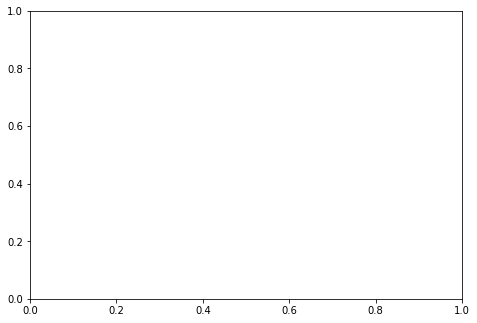

In [29]:
total_mesh = su.decompress_pickle("total_mesh")
total_mesh_graph = su.decompress_pickle("total_mesh_graph")
total_mesh_correspondence = su.decompress_pickle("total_mesh_correspondence")


In [22]:
curr_unmarked_faces = su.decompress_pickle("curr_unmarked_faces")
total_mesh_graph = su.decompress_pickle("total_mesh_graph")
total_mesh_correspondence = su.decompress_pickle("total_mesh_correspondence")
submesh_indices = su.decompress_pickle("submesh_indices")

In [21]:
import general_utils as gu
gu = reload(gu)

try:
    raise Exception("new exception")
    raise gu.CGAL_skel_error("No CGAL skeleton")
    
except gu.CGAL_skel_error as error: 
    print(error.msg)
    


Exception: new exception

In [ ]:
nviz.plot_soma_limb_concept_network(neuron_obj)

In [ ]:
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")

# Sending the data to the Neuron Object

In [ ]:
nru = reload(nru)
save_time = time.time()
neuron_obj.save_compressed_neuron(output_folder="/notebooks/test_neurons/Fusion_decomp/",
                                 export_mesh=True,
                                 suppress_output=True)
print(f"Save time = {time.time() - save_time}")

In [ ]:
import neuron_visualizations as nviz
returned_colors = nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L6="all"),
                                       return_color_dict=True)